In [1]:
import deeptrack as dt
import numpy as np
from matplotlib import pyplot as plt
import cv2

# Images from dataset

Length of training data: 25


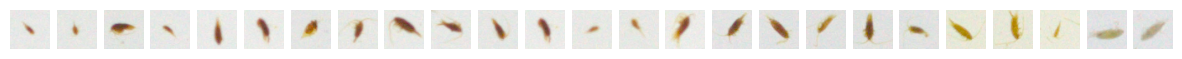

In [2]:
load_data = np.load('copepod_crops.npz')
training_images = [load_data[file] for file in load_data.files]
num_images = len(training_images)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
for i, image in enumerate(training_images):
    axs[i].imshow(image)
    axs[i].axis('off')

print(f"Length of training data: {num_images}")


# Defining the Encoder-Decoder
As the image is a 3 channel color image, 
the encoder decoder needs to be constructed in order to handle this.

In [3]:
import deeplay as dl 
from deeplay.components import ConvolutionalEncoder2d, ConvolutionalDecoder2d
import torch
import torch.nn as nn

#Hyperparams
channel_param  = [48*2,48*2]
input_dims     = np.shape(training_images[0])
color_channels = input_dims[-1]
latent_size    = 4
red_dims       = [int(latent_size / ( 2 **len(channel_param))) for latent_size in input_dims]

#Encoder:
color_encoder = ConvolutionalEncoder2d(
            color_channels,
            channel_param,
            channel_param[-1],
        )
color_encoder.postprocess.configure(nn.Flatten)

#Decoder:
color_decoder = ConvolutionalDecoder2d(channel_param[0],
                                       channel_param   ,
                                       color_channels  ,
                                       out_activation=nn.Sigmoid,)
color_decoder.preprocess.configure(
    nn.Unflatten,
    dim=1,
    unflattened_size=(channel_param[0],red_dims[0],red_dims[1]),
)



# With the encoder and decoder defined, initialize the VAE.

In [4]:
vae = dl.VariationalAutoEncoder(
    input_size = input_dims   ,
    latent_dim = latent_size  ,
    channels   = channel_param,
    encoder    = color_encoder,
    decoder    = color_decoder,
    reconstruction_loss = torch.nn.BCELoss(reduction="sum"),
    beta       = 1,
).create()
print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1-2): 2 x PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=13824, out_features=4, bias=True)
  (fc_var): Linear(in_features=13824, out_features=4, bias=True)
  (fc_dec): Linear(in_features=4, out_features=13824, bias=True)
  (decoder): ConvolutionalDecoder2d(
    (preprocess): Unflatten(dim=1, unflattened_size=(96, 12, 12))
    (blocks): LayerList(
     

# Training Pipeline

In [21]:
from torch.utils.data import DataLoader
import random
random_crop = dt.Value(lambda: random.choice(training_images))
image_pipeline = (
    dt.Value(random_crop)
    >> dt.NormalizeMinMax()
    >> dt.FlipLR(lambda: random.uniform(0,0.4))
    >> dt.FlipUD(lambda: random.uniform(0,0.4))
    >> dt.FlipDiagonal(lambda: random.uniform(0,0.4))
    >> dt.MoveAxis(2,0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

train_dataset = dt.pytorch.Dataset(image_pipeline & image_pipeline,length=200)
train_loader  = DataLoader(train_dataset,batch_size=5,shuffle=True,num_workers=5)

# Training

In [22]:
vae_trainer = dl.Trainer(max_epochs=200,accelerator="auto")
vae_trainer.fit(vae,train_loader)

/home/alex/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 168 K 
1 | fc_mu               | Linear                 | 55.3 K
2 | fc_var              | Linear                 | 55.3 K
3 | fc_dec              | Linear                 | 69.1 K
4 | decoder             | ConvolutionalDecoder2d | 242 K 
5 | reconstruction_loss | BCELoss                | 0     
6 | train_metrics       | MetricCollection       | 0     
7 | val_metrics         | MetricCollection       | 0     
8 | test_metrics        | MetricCollection       | 0     
9 | optimizer           | Adam                   | 0     
---------------------------------------------------------------
591 K     Trainable params
0         Non-t

Epoch 199: 100%|██████████| 40/40 [00:02<00:00, 15.65it/s, v_num=22, train_rec_loss_step=1.19e+4, train_KL_step=44.70, train_total_loss_step=1.2e+4, train_rec_loss_epoch=1.13e+4, train_KL_epoch=49.20, train_total_loss_epoch=1.14e+4] 


# Sampling Latent space

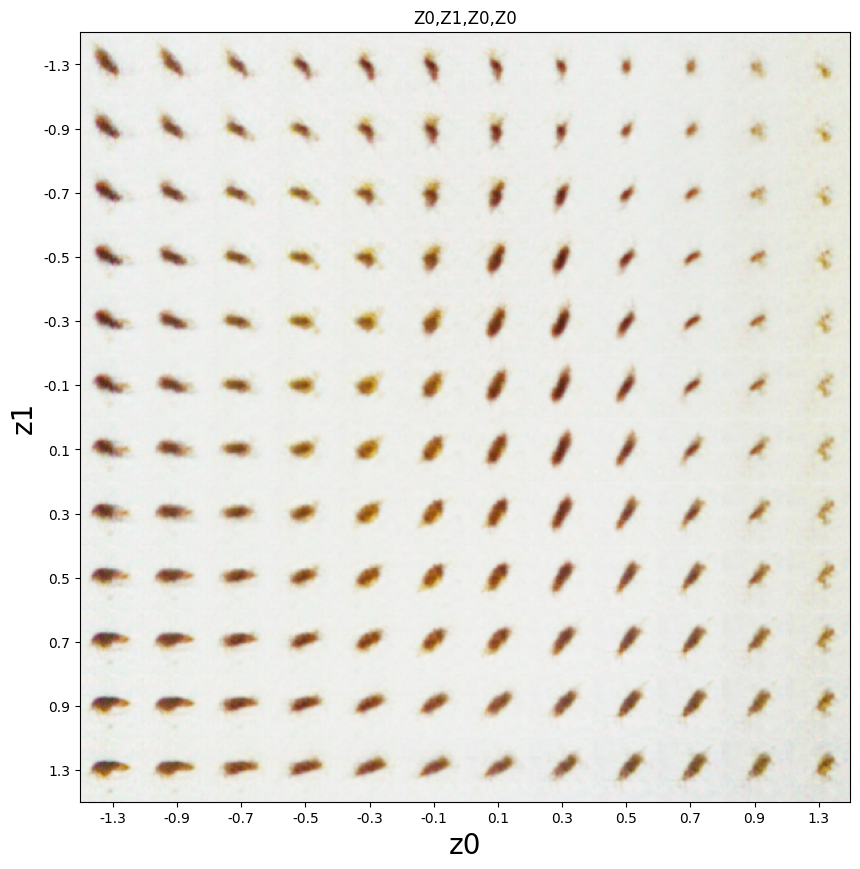

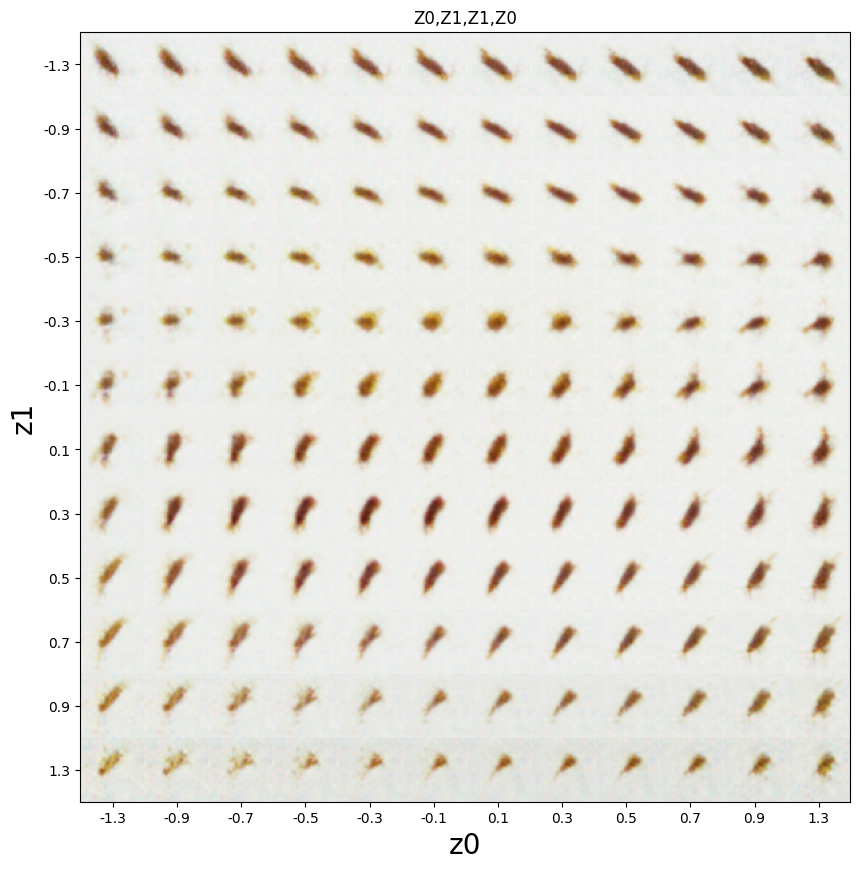

In [28]:
from torch.distributions.normal import Normal
img_num = 12
img_size = 48

z0_grid = Normal(0, 1).icdf(torch.linspace(0.1, 0.9, img_num))
z1_grid = Normal(0, 1).icdf(torch.linspace(0.1, 0.9, img_num))
image = np.zeros((img_num * img_size, img_num * img_size,3))
for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z=torch.stack((z0,z1,z0,z0)).unsqueeze(0)
        generated_image = vae.decode(z).clone().detach().numpy()
        generated_image = generated_image.transpose(0, 2, 3, 1).squeeze() 
        
        image[
            i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size, 
            :
        ] = generated_image

plt.figure(figsize=(10, 10))
plt.title("Z0,Z1,Z0,Z0")
plt.imshow(image, cmap="gray")
plt.xticks(
np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
np.round(z0_grid.numpy(), 1),
)
plt.yticks(
np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
np.round(z1_grid.numpy(), 1),
)
plt.xlabel("z0", fontsize=20)
plt.ylabel("z1", fontsize=20)
plt.show() 



image = np.zeros((img_num * img_size, img_num * img_size,3))
for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z=torch.stack((z0,z1,z1,z1)).unsqueeze(0)
        generated_image = vae.decode(z).clone().detach().numpy()
        generated_image = generated_image.transpose(0, 2, 3, 1).squeeze() 
        image[
            i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size, 
            :
        ] = generated_image

plt.figure(figsize=(10, 10))
plt.title("Z0,Z1,Z1,Z0")
plt.imshow(image, cmap="gray")
plt.xticks(
np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
np.round(z0_grid.numpy(), 1),
)
plt.yticks(
np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
np.round(z1_grid.numpy(), 1),
)
plt.xlabel("z0", fontsize=20)
plt.ylabel("z1", fontsize=20)
plt.show() 


# Test feed image to the decoder

In [24]:
test_dataset = dt.pytorch.Dataset(image_pipeline, length=120 )
test_loader  = DataLoader(test_dataset,batch_size=10,shuffle=False)
mu_list = []

for img in test_loader:
    print(img)
    input_img = img.float() 
    mu, _ = vae.encode(input_img.float())
    mu_list.append(mu)

mu_tensor = torch.cat(mu_list,dim=0).detach().numpy()

generated_image = vae.decode(test_image).detach().numpy()



[tensor([[[[0.9347, 0.9469, 0.9551,  ..., 0.9592, 0.9592, 0.9633],
          [0.9469, 0.9265, 0.9265,  ..., 0.9306, 0.9306, 0.9306],
          [0.9469, 0.9347, 0.9265,  ..., 0.8980, 0.9184, 0.9306],
          ...,
          [0.9469, 0.9429, 0.9265,  ..., 0.9551, 0.9429, 0.9429],
          [0.9388, 0.9347, 0.9347,  ..., 0.9510, 0.9347, 0.9429],
          [0.9265, 0.9265, 0.9306,  ..., 0.9633, 0.9510, 0.9347]],

         [[0.9184, 0.9184, 0.9429,  ..., 0.9306, 0.9265, 0.9143],
          [0.9265, 0.9102, 0.9143,  ..., 0.9347, 0.9224, 0.9061],
          [0.9265, 0.9265, 0.9224,  ..., 0.9388, 0.9347, 0.9306],
          ...,
          [0.9429, 0.9306, 0.9306,  ..., 0.9388, 0.9347, 0.9347],
          [0.9429, 0.9306, 0.9347,  ..., 0.9388, 0.9224, 0.9265],
          [0.9388, 0.9265, 0.9388,  ..., 0.9469, 0.9469, 0.9388]],

         [[0.9224, 0.9143, 0.9551,  ..., 0.9265, 0.9224, 0.9306],
          [0.9469, 0.9429, 0.9347,  ..., 0.9306, 0.9347, 0.9306],
          [0.9388, 0.9388, 0.9224,  ..., 

AttributeError: 'list' object has no attribute 'float'